# Libri speech Classification baselines 

## Imports

In [1]:
from __future__ import absolute_import, division, print_function

# General
import sys 
import os
from os import path, makedirs
import shutil
import numpy as np 


sys.path.insert(0, '../../Utils')
sys.path.insert(1, os.path.join(sys.path[0], '..'))

# For LibriSpeech download
import codecs
import fnmatch
import pandas as pd
import requests
import subprocess
import tarfile
import unicodedata

from tensorflow.python.platform import gfile

# For PyBrain approach
import soundfile as sf            # To read .flac files.   
import speech_recognition as sr   # pip install SpeechRecognition.
from pybrain.datasets                import ClassificationDataSet
from pybrain.supervised.trainers     import BackpropTrainer
from pybrain.tools.customxml.networkreader import NetworkReader
from pybrain.tools.customxml.networkwriter import NetworkWriter

#visualization imports:
import matplotlib.pyplot as plt
%matplotlib inline

print("Python: %s" % sys.version)

Python: 3.6.5 (default, Jun 21 2018, 23:07:39) 
[GCC 5.4.0 20160609]


## Data parameters

In [2]:
# Frames and frequencies
durationCheck = 10.      # Only consider files with 10 or more seconds of audio.
deltaT        = 0.2      # Audio frame size is 0.2 seconds.
noisy         = 0.1      # This sets the limit for static, i.e. pauses in speech.
lim1 = 10; lim2 = 410    # Lower and upper frequencies. 
                         # For the above parameters and 16 kHz sampling, this range is about 50 - 2000 Hz. 
# Path names   
audioType  = ".flac"               # Flac files. 
datapath   = "data/LibriSpeech/"        # Path where audio files are located.
trainSet   = "train-speakerID/"        # Training set.
cvSet      = "cv-speakerID/"           # Cross-Validation set.
tstSet     = "test-speakerID/"         # Test set. 
stem       = "nn"                  # Output network filename stem.    

numSpeakers = 10 #make this an even #

if numSpeakers == 10:
    # These are the speakers.
    # Female: 19, 32, 39, 40, 83
    # Male: 26, 27, 78, 405, 196
    speakers = ["19/",
                "26/",
                "32/",
                "27/",
                "39/",
                "78/",
                "40/",
                "405/", 
                "83/",
                "196/"]

maxminFile = "min_max_values" + str(numSpeakers) + ".dat"  # File to store max and min values for each frequency bin.
outfolder  = "networks" + str(numSpeakers) + "/"           # Folder to store trained networks.

if not os.path.isdir(outfolder):
    os.mkdir(outfolder)

numFeatures = lim2-lim1

## Hyperparameters

In [3]:
possibleOutputs   = 1       # Only 1 kind of output, i.e. each sample is one speaker.
numHiddenNodes    = 10      # Nodes per hidden layer.
numHiddenLayers   = 5       # 5 layers.
numTrainingEpochs = 0      # Train 'n' epochs.

## Training settings

In [4]:
first = True            # Set up a network.
first = False            # We already have a network.
nnFile = "nn79.xml"      # Most recent. Starting file name to read from.
st = 80                  # Starting file to write to.

#CV settings
lastN = 79 #the last network there is an XML file for in the networks directory
firstN = 60 #first network to start with

## Load LibriSpeech data set

In [5]:
#all the code for data loading that isn't needed for visualization:
from LS_UTILS import Data_load
Data_load._download_and_preprocess_data('data/')

Found archive "data/train-clean-100.tar.gz" - not downloading.
Found archive "data/train-clean-360.tar.gz" - not downloading.
Found archive "data/dev-clean.tar.gz" - not downloading.
Found archive "data/dev-other.tar.gz" - not downloading.
Found archive "data/test-clean.tar.gz" - not downloading.
Found archive "data/test-other.tar.gz" - not downloading.
Extracting librivox data if not already extracted...


## Load speaker metadata and select speakers

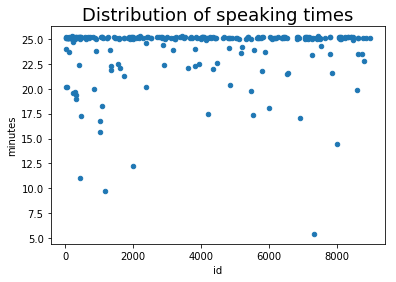

In [6]:
#1. load data from text to pandaframe

# Note: before running this, change 
# 60   | M | train-clean-100  | 20.18 | |CBW| Simon
# to
# 60   | M | train-clean-100  | 20.18 | CBW Simon
df = pd.read_table('data/LibriSpeech/SPEAKERS.TXT',header = 11,sep = '|')
df.columns = ['id','sex','subset','minutes','name']
train25 = df[df['subset']== ' train-clean-100  ']
train25.plot.scatter('id','minutes')
plt.title('Distribution of speaking times',size = 18);

In [7]:
# 2. Pick a gender balanced group of speakers w/long speaking times, and print their names

train25 = train25[train25['minutes'] >= 25]
print('# potential speakers:',len(train25))

df_speaker = train25[train25['sex']==' M '][0:numSpeakers//2]
df_speaker = df_speaker.append(train25[train25['sex']==' F '][0:numSpeakers//2]).sort_index()

speakers = df_speaker['id'].values
speakers = [str(i)+'/' for i in speakers]

# potential speakers: 187


## Split data from individual speakers into train, test & cross-validation folders

In [8]:
#all the code for data splitting that isn't needed for visualization:
from LS_UTILS import Move_data
Move_data.main(speakers,datapath,trainSet,cvSet,tstSet)

## 1. PyBrain Neural Net approach

  below ~15 cells adapted from https://github.com/aravindnatarajan/SpeakerRecognition

  Speaker Identification. Data comes from http://www.openslr.org/12/
  
  Task: Given 't' seconds of speech, identify the speaker.
  
  10-class classification: 5 male and 5 female speakers.
  
  Training on about 10 minutes of speech per speaker.

In [9]:
#all the code for networks that isn't needed for visualization:
from LS_UTILS import Network_funcs

In [ ]:
# Get data,
# as well as locations where speaker 'i' ends, and speaker 'j' begins.
trnX,trnY,trnIdx = Network_funcs.getDataSpeakers(trainSet,speakers,datapath,audioType,durationCheck,deltaT,lim1,
                                                 lim2,numFeatures,noisy)  

Getting data for speaker: 19/
Getting data for speaker: 26/
Getting data for speaker: 39/
Getting data for speaker: 40/


In [ ]:
print('Xdim,ydim',np.shape(trnX), np.shape(trnY)    )
trnRows = np.shape(trnX)[0]

In [ ]:
# Make some plots.
# Frequency index from 0...400 represent a range from 50 - 2000 Hz.
# Time index from 0 to 150 represent a range from 0 - 30 seconds.
plt.title("Speaker #1 (ID# 19/, Female), 30 seconds")
plt.xlabel("Time Index")
plt.ylabel("Frequency Index")
plt.imshow(trnX[trnIdx[0]:trnIdx[0]+150,:].T,origin="lower",aspect=0.3)

In [ ]:
plt.title("Speaker #2 (ID# 26/, Male), 30 seconds")
plt.xlabel("Time Index")
plt.ylabel("Frequency Index")
plt.imshow(trnX[trnIdx[1]:trnIdx[1]+150,:].T,origin="lower",aspect=0.3)

In [ ]:
# Find min and max values for each frequency bin using Training data only.
# Normalize data to lie in the range (0,1).
minArray = []; maxArray = []
for i in range(0,numFeatures):
  minArray.append(np.min(trnX[:,i]))
  maxArray.append(np.max(trnX[:,i]))    

f = open(maxminFile, "w")
for i in range(0,numFeatures):
  f.write(str(maxArray[i]) + " " + str(minArray[i]) + "\n")
f.close()      

for i in range(0,trnRows):
  for j in range(0,numFeatures):
    trnX[i,j] = (trnX[i,j]-minArray[j])/(maxArray[j]-minArray[j])  

## Network training

In [ ]:
# Now, we train the neural network.
trndata = ClassificationDataSet(numFeatures, possibleOutputs, nb_classes=numSpeakers)
for row in range(0,trnRows):
  tempListOut = []; tempListIn = []
  tempListOut.append(int(trnY[row]))
  for i in range(0,numFeatures): 
    tempListIn.append(trnX[row,i])
    
  trndata.addSample(tempListIn,tempListOut)
trndata._convertToOneOfMany()

if first:    # For the first time, we need to create the neural network.
  nn = Network_funcs.setupNetwork(numHiddenNodes,numHiddenLayers,numFeatures,numSpeakers)

else:        # We already have a network.
  nn = NetworkReader.readFrom(outfolder+nnFile)
    
trainer = BackpropTrainer(nn, dataset=trndata, momentum=0., verbose=True, weightdecay=0.)  
for i in range(numTrainingEpochs): 
  trainer.trainOnDataset(dataset=trndata)    
  if (i+1)%5 == 0:
    NetworkWriter.writeToFile(nn, outfolder+stem+str(st)+".xml")  # Save the network, to save time.
    st += 1
    print (i+1)

In [ ]:
# Data for cross-validation and testing.
# We use the cross validation data set to determine the network architecture,
# i.e. depth and width of the network, type of activation function, etc.
#
cvX,cvY,cvIdx = Network_funcs.getDataSpeakers(cvSet,speakers,datapath,audioType,durationCheck,deltaT,lim1,
                                                 lim2,numFeatures,noisy)  
tstX,tstY,tstIdx = Network_funcs.getDataSpeakers(tstSet,speakers,datapath,audioType,durationCheck,deltaT,lim1,
                                                 lim2,numFeatures,noisy)  
cvRows = np.shape(cvX)[0]; tstRows = np.shape(tstX)[0]

f = open(maxminFile)    # Read the max and min values obtained from the training set.
maxi = []; mini = []
for lp in range(0,numFeatures):
  line = f.readline().split()
  maxi.append(float(line[0]))
  mini.append(float(line[1]))
f.close()

# Normalize to put data in the range (0,1).
for i in range(0,cvRows):
  for j in range(0,numFeatures):
    cvX[i,j] = (cvX[i,j]-mini[j])/(maxi[j]-mini[j])  

for i in range(0,tstRows):
  for j in range(0,numFeatures):
    tstX[i,j] = (tstX[i,j]-mini[j])/(maxi[j]-mini[j])  

In [ ]:
# Performance on the CV set, as a function of training epoch.
# We stop when we see signs of overfitting.
# Performance on the CV set is also used to determine the neural network architecture.
#

print("CV Set - Performance on 0.2 seconds of data.")
X = []; Y = []
for q in range(firstN,lastN+1):
  net = outfolder+stem+str(q)+".xml"
  nn = [NetworkReader.readFrom(net)]
  st = 1
  A,c = Network_funcs.tstClassifier(nn,cvX,cvY,cvIdx,st,numSpeakers,numFeatures)
#   if q%5 == 0:
  print(net,st*deltaT,np.mean(A))
  X.append((q+1)*5)
  Y.append(np.mean(A))

## Get training accuracy (after CV)

In [ ]:
print("Train Set - Performance on 0.2 seconds of data.")
X = []; Y = []
for q in range(firstN,lastN+1):
  net = outfolder+stem+str(q)+".xml"
  nn = [NetworkReader.readFrom(net)]
  st = 1
  A,c = Network_funcs.tstClassifier(nn,trnX,trnY,trnIdx,st,numSpeakers,numFeatures)
#   if q%5 == 0:
  print(net,st*deltaT,np.mean(A))
  X.append((q+1)*5)
  Y.append(np.mean(A))

In [ ]:
#  The network is trained using performance on the CV set.
#  Therefore, we cannot report perfomance on the CV set anymore.
#  So, we use the other hold-out data set, i.e. the Test set.
#
print("Test Set - Performance on 0.2 seconds of data.")
X = []; Y = []
for q in range(firstN),lastN):
  net = outfolder+stem+str(q)+".xml"
  nn = [NetworkReader.readFrom(net)]
  st = 1
  A,c = tstClassifier(nn,tstX,tstY,tstIdx,st)
#   if q%5 == 0:
  print(net,st*deltaT,np.mean(A))
  X.append((q+1)*5)
  Y.append(np.mean(A))

In [ ]:
plt.xlabel("Training epoch index")
plt.ylabel("Accuracy averaged over 10 speakers")
plt.title("Performance on the test set with 0.2 seconds of speech")
plt.plot(X,Y)
plt.show()

In [ ]:
#  Accuracy for t = 0.2,0.4,0.6,0.8,1.0,... 3 seconds.
#
print("Test Set: Accuracy (averaged over speakers) for t = 0.2,0.4,0.6,... seconds")
# Use 5 classifiers - the accuracy improves a little with an ensemble of networks.
# For better results, use networks that were initialized with different random seeds.
nets = ["nn19.xml", "nn39.xml", "nn47.xml", "nn23.xml", "nn18.xml"]
nets = ["nn5.xml", "nn10.xml", "nn15.xml", "nn20.xml", "nn29.xml"]
nets = ["nn5.xml", "nn9.xml", "nn14.xml", "nn19.xml","nn24.xml"]
nns = [NetworkReader.readFrom(outfolder+net) for net in nets]
X = []; Y = []
maxT = 3.   # 3 seconds.
for st in range(1,int(maxT/deltaT)+1):
  A,c = tstClassifier(nns,tstX,tstY,tstIdx,st)
  print(st*deltaT,np.mean(A))
  X.append(st*deltaT)
  Y.append(np.mean(A))

In [ ]:
plt.plot(X,Y)
plt.xlabel("Number of seconds of speech")
plt.ylabel("Accuracy averaged over 10 speakers")
plt.title("Classifier performance on the test set")
plt.show()

### classifier notes:
10: each 20 files were started from a new seed
100: 0-4 is one set; 5-24 another; 25-34; 35-44; 45-54

## LibriSpeech Results

In [ ]:
#table with 
columns = ['Training epochs', '# speakers', 'audio duration', 'Train accuracy', 'Test accuracy']

# do this for 10 & 100 speakers
# .2 S & 3 S
#sufficient training and over-training



In [ ]:
# Print the confusion matrix of True/False positives.
# First row is speaker 1. The columns are predictions for speaker 1,2,3,...
#
nns  = [NetworkReader.readFrom(outfolder+net) for net in nets]
A,c = tstClassifier(nns,tstX,tstY,tstIdx,1)
print("Confusion matrix: T = 0.2 s")
print("Predicted speaker -->")
print("F\tM\tF\tM\tF\tM\tF\tM\tF\tM\n")

A,c = tstClassifier(nns,tstX,tstY,tstIdx,5)
print(c)

A,c = tstClassifier(nns,tstX,tstY,tstIdx,10)
print("F\tM\tF\tM\tF\tM\tF\tM\tF\tM\n")
print(c)

In [ ]:
samples = [datapath+tstSet+"19/227/19-227-0016.flac",
           datapath+tstSet+"26/496/26-496-0021.flac",
           datapath+tstSet+"405/130895/405-130895-0031.flac"]

expected = [
"",
  
"",
  
""
]

r = sr.Recognizer()
i = 0
for sample in samples:
  with sr.AudioFile(sample) as source:
    audio = r.record(source)      
    s = r.recognize_google(audio)
    print("Reading file: " + sample)
    print("Expected:")
    print(expected[i])
    print("\n"[:-1])
    print("Obtained (Google translator):")
    print(s)
    print("\n"[:-1])
    i += 1

## 2. Approach: Siamese network

In [ ]:
# add this to ~/.bashrc for the package to run:
#export PYTHONPATH=$PYTHONPATH:/home/nlopatina/nlopatina/voicemap
# adapted from https://github.com/oscarknagg/voicemap






# from keras.layers import Input, Subtract, Dense, Lambda
# from keras.models import Model
# import keras.backend as K

# def build_siamese_network(encoder, input_shape):
#     input_1 = Input(input_shape)
#     input_2 = Input(input_shape)
    
#     # `encoder` is any predefined network that maps a single sample 
#     # into an embedding space.
#     # `encoder` should take an input with shape (None,) + input_shape
#     # and produce an output with shape (None, embedding_dim). 
#     # None indicates the batch dimension.
#     encoded_1 = encoder(input_1)
#     encoded_2 = encoder(input_2)
    
#     # Here I calculate the eucliden distance between the two encoded
#     # samples though other distances can be used
#     embedded_distance = Subtract()([encoded_1, encoded_2])
#     embedded_distance = Lambda(
#         lambda x: K.sqrt(K.mean(K.square(x), axis=-1,keepdims=True))
#     )(embedded_distance)
    
#     # Add a dense+sigmoid layer here in order to use per-pair, binary 
#     # similar/dissimilar labels
#     output = Dense(1, activation='sigmoid')(embedded_distance)
    
#     siamese = Model(inputs=[input_1, input_2], outputs=output)
    
#     return siamese

# # adapted from https://medium.com/analytics-vidhya/building-a-speaker-identification-system-from-scratch-with-deep-learning-f4c4aa558a56